### 1. Error Analysis Conclusions & Work Plan

#### **Conclusions from Error Analysis**
Based on the initial error analysis, the following factors were identified as the main causes of errors in the baseline model:

1. **Skewed Distributions**
   - Features like `residual sugar` and `total sulfur dioxide` have highly skewed distributions.
   - Skewness introduces bias in the model’s learning process, leading to poor generalization on extreme values and outliers.

2. **Underrepresentation of Key Patterns**
   - Certain combinations of features (e.g., very low `residual sugar` with high `total sulfur dioxide`) are rare in the dataset, causing the model to underperform on these edge cases.

3. **Feature Redundancy**
   - High correlation between `free sulfur dioxide` and `total sulfur dioxide` indicates redundancy, which may confuse the model and lead to inefficiencies in learning.

4. **Features with Low Importance**
   - Features like `pH` and `type` showed minimal correlation with `quality` and low importance in the baseline model.

5. **Bias-Variance Tradeoff**
   - The current model may overfit dominant patterns while underfitting on edge cases, likely due to suboptimal hyperparameters or insufficient regularization.

6. **Outliers**
   - Outlier samples with extreme values in features like `density`, `alcohol`, and `residual sugar` significantly impact the model’s performance.


**Work Plan for Addressing Errors**

1. **Handling Skewed Distributions**
   - Apply log transformations to skewed features (`residual sugar`, `total sulfur dioxide`) to stabilize variance and reduce skewness.
   - Use visualizations (e.g., histograms, boxplots) to confirm the transformation’s effect.

2. **Outlier Handling**
   - Detect and mitigate outliers using techniques like:
     - **IQR-based capping:** Cap extreme values beyond 1.5×IQR.
     - **Robust scaling:** Apply transformations to reduce the impact of outliers.
   - Evaluate the impact of removing or scaling outliers on model performance.

3. **Reducing Feature Redundancy**
   - Create a new composite feature: `sulfur dioxide ratio` (`free sulfur dioxide / total sulfur dioxide`) to capture relationships between redundant features.
   - Remove `free sulfur dioxide` and `total sulfur dioxide` after validating the new feature’s utility.

4. **Advanced Feature Engineering**
   - Add a new composite feature: `density_alcohol_ratio` (`density / alcohol`) to capture interactions between density and alcohol, which are independently impactful.
   - Visualize the new feature's relationship with the target variable.

5. **Feature Selection**
   - Evaluate the impact of low-importance features like `pH` and `type`:
     - If they do not significantly improve performance, remove them to simplify the model.
   - Use feature importance metrics to justify the removal.

6. **Hyperparameter Tuning**
   - Optimize key hyperparameters such as `max_depth`, `learning_rate`, `n_estimators`, and `min_child_weight` using Grid Search or Randomized Search.
   - Adjust regularization parameters (e.g., `lambda`, `alpha`) to balance bias and variance effectively.

---

### 2. Improving Model Performance

The following actions were taken to address weaknesses in the baseline model:

1. **Skewed Distributions**:
   - Log transformations were applied to stabilize variance and reduce bias in features like `residual sugar` and `total sulfur dioxide`.

2. **Outliers**:
   - Extreme values in features like `density` and `alcohol` were mitigated to minimize their negative impact.

3. **Feature Redundancy**:
   - The redundant features `free sulfur dioxide` and `total sulfur dioxide` were replaced by a composite feature (`sulfur dioxide ratio`).

4. **Advanced Feature Engineering**:
   - Created a new composite feature: `density_alcohol_ratio` to capture the interaction between density and alcohol, which individually impact wine quality.

5. **Low-Importance Features**:
   - Features such as `pH` and `type` were evaluated for their contribution and were removed due to their minimal impact on model performance.

6. **Hyperparameter Tuning**:
   - Optimized key parameters (e.g., `max_depth`, `learning_rate`, `lambda`, `alpha`) to balance model complexity and prediction accuracy.

These steps collectively enhanced the model's accuracy, robustness, and interpretability.

---


In [3]:
# Load necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler 

# Load the dataset
data = pd.read_csv('wine-quality-white-and-red.csv')

# Encode categorical column 'type' if it exists
if 'type' in data.columns:
    label_encoder = LabelEncoder()
    data['type'] = label_encoder.fit_transform(data['type'])  # Convert 'type' to numerical

# Prepare features (X) and target (y)
X = data.drop(columns=['quality'])  # Features
y = data['quality']  # Target variable

**1. Handling Skewed Distributions**

**Explanation:**
Features like `residual sugar` and `total sulfur dioxide` exhibit skewed distributions, which can:
- **Bias the model's learning process** by overemphasizing frequent values and underrepresenting extreme ones.
- Lead to poor generalization, especially when the model encounters rare or extreme feature values in the test set.

To address this:
- **Log transformations** were applied to stabilize variance and reduce skewness.
- Histograms visualize the overall distribution before and after transformation, demonstrating how the skewness is reduced.


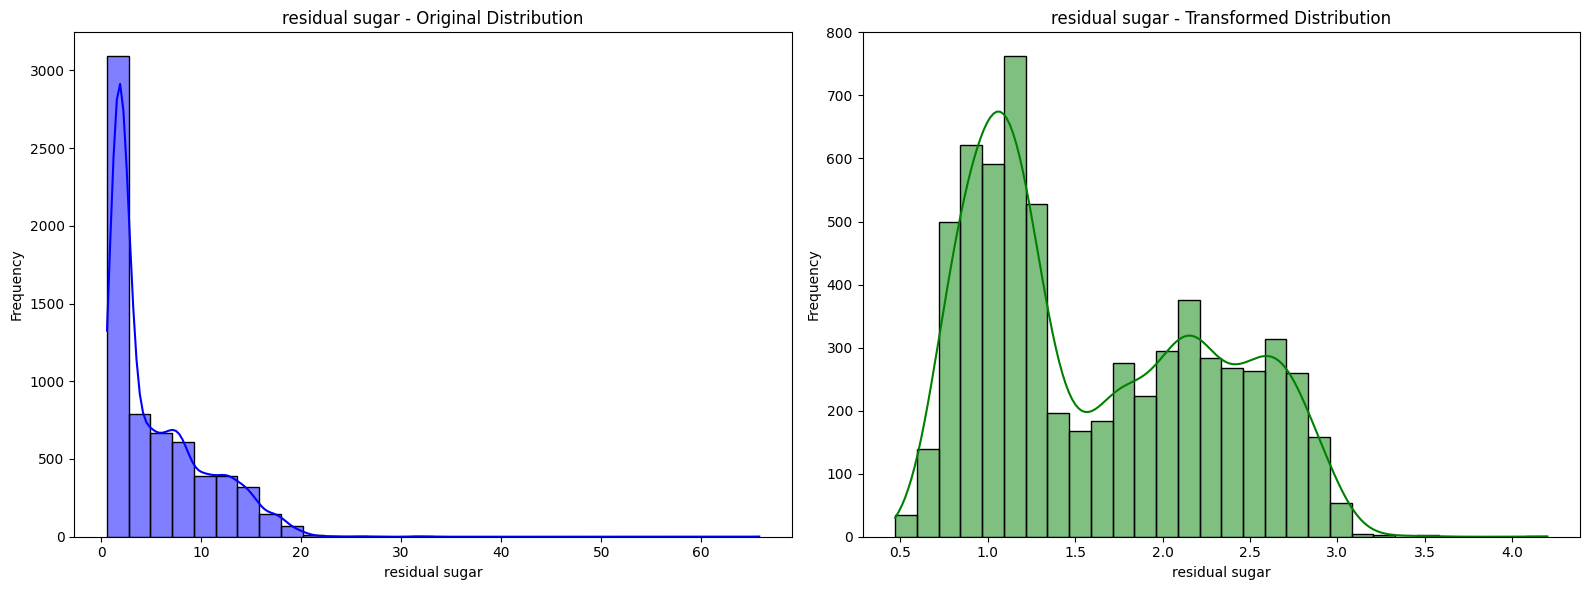

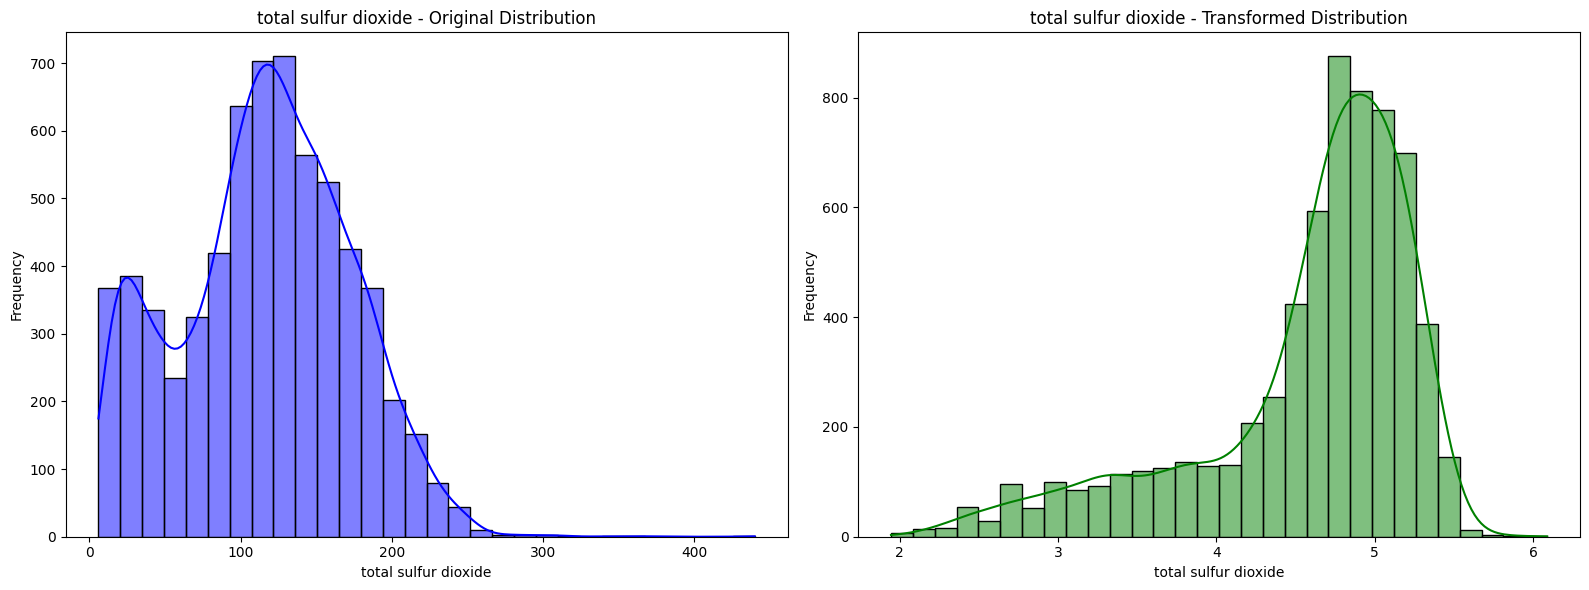

In [4]:
# Visualization of skewed features before and after transformation
skewed_features = ['residual sugar', 'total sulfur dioxide']

for feature in skewed_features:
    if feature in X.columns:  # Ensure the feature exists
        # Create side-by-side visualizations
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Original distribution
        sns.histplot(X[feature], kde=True, bins=30, ax=axes[0], color='blue')
        axes[0].set_title(f'{feature} - Original Distribution')
        axes[0].set_xlabel(feature)
        axes[0].set_ylabel('Frequency')

        # Apply log transformation
        X[feature] = np.log1p(X[feature])

        # Transformed distribution
        sns.histplot(X[feature], kde=True, bins=30, ax=axes[1], color='green')
        axes[1].set_title(f'{feature} - Transformed Distribution')
        axes[1].set_xlabel(feature)
        axes[1].set_ylabel('Frequency')
        
        # Adjust layout
        plt.tight_layout()
        plt.show()


**Results and Insights:**

1. **Residual Sugar**:
   - **Before Transformation**:
     - Highly right-skewed distribution, with most values concentrated at the lower end.
   - **After Transformation**:
     - Distribution approaches normality, with reduced skewness. The spread of values is more uniform.

2. **Total Sulfur Dioxide**:
   - **Before Transformation**:
     - Moderately right-skewed distribution, with a concentration of values in the lower range.
   - **After Transformation**:
     - Distribution becomes more symmetric, allowing the model to better capture patterns in the data.

---

**Impact on the Model**:
- **Improved Learning**: The reduction in skewness helps the model generalize better, as extreme values no longer dominate the learning process.
- **Stabilized Variance**: The log transformations ensure that the variance of the features is more consistent, reducing potential bias in predictions.


**3. Outlier Handling**
**Why Handle Outliers?**

Outliers are extreme values that can distort the model by:
- Skewing distributions and statistical measures.
- Reducing generalization and focusing on noise instead of patterns.
**Approach**
**IQR-Based Capping**:
   - Capped values beyond \( Q1 - 1.5 \times \text{IQR} \) and \( Q3 + 1.5 \times \text{IQR} \).
   - Reduced extreme values while preserving meaningful patterns.

**Features with Outliers**
From analysis, the following features had significant outliers:
- `residual sugar`
- `total sulfur dioxide`
- `density`
- `alcohol`
- `chlorides`


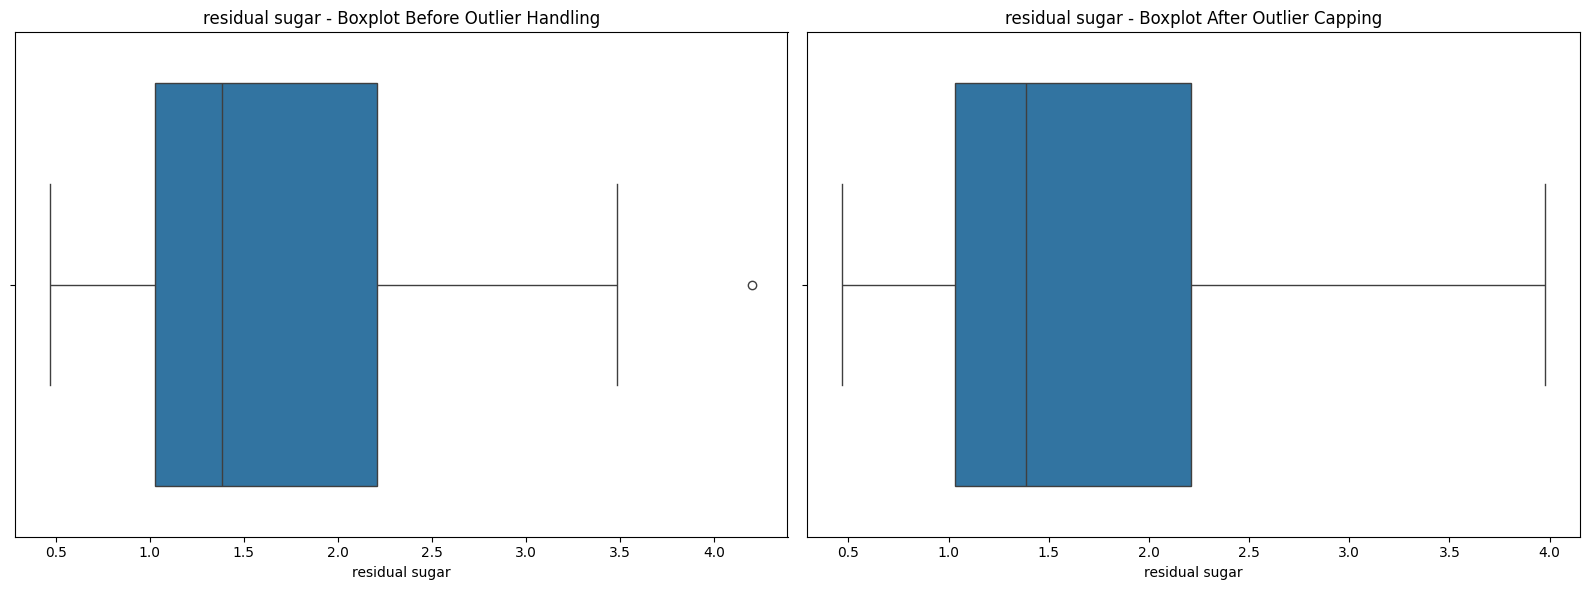

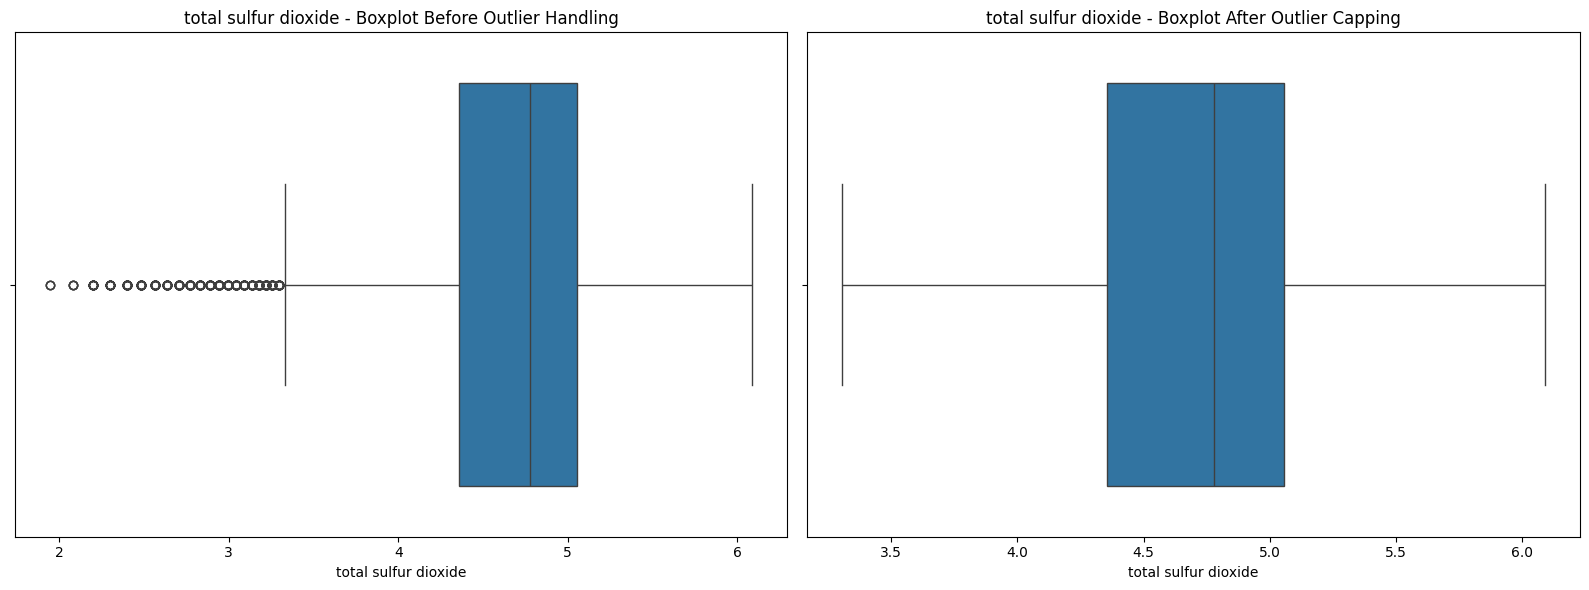

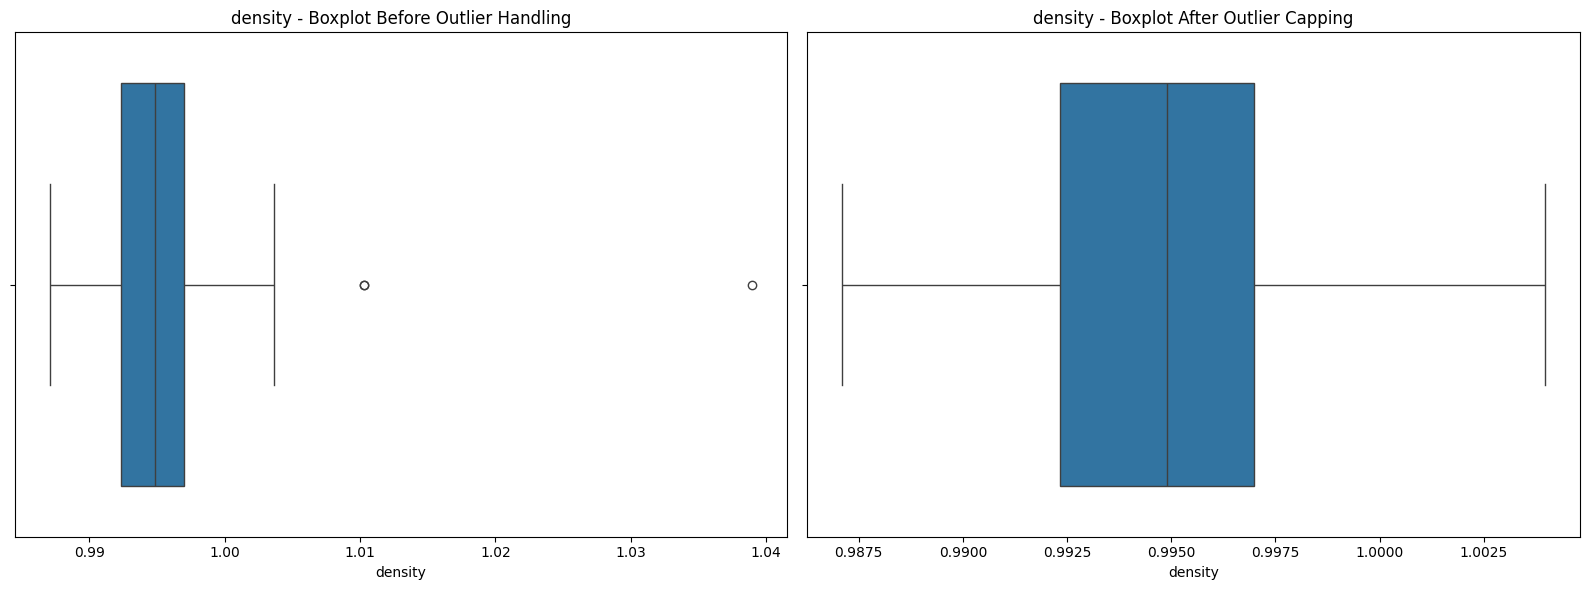

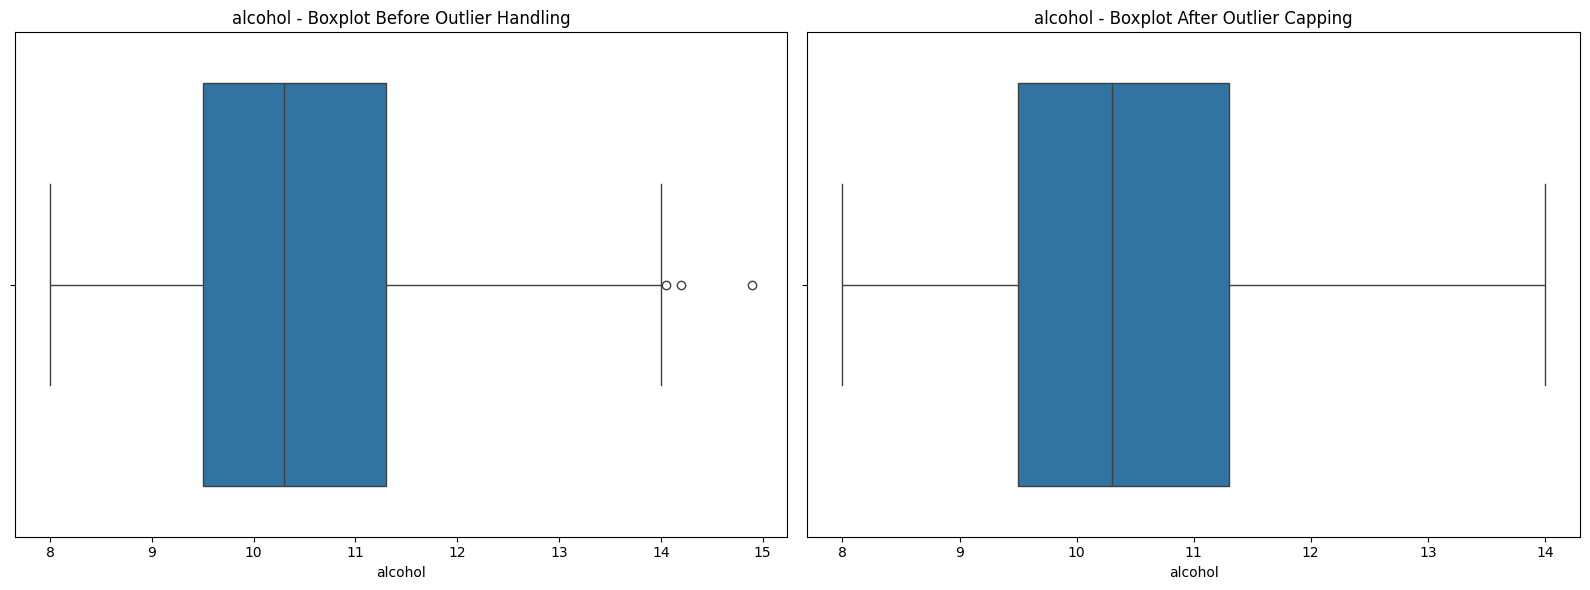

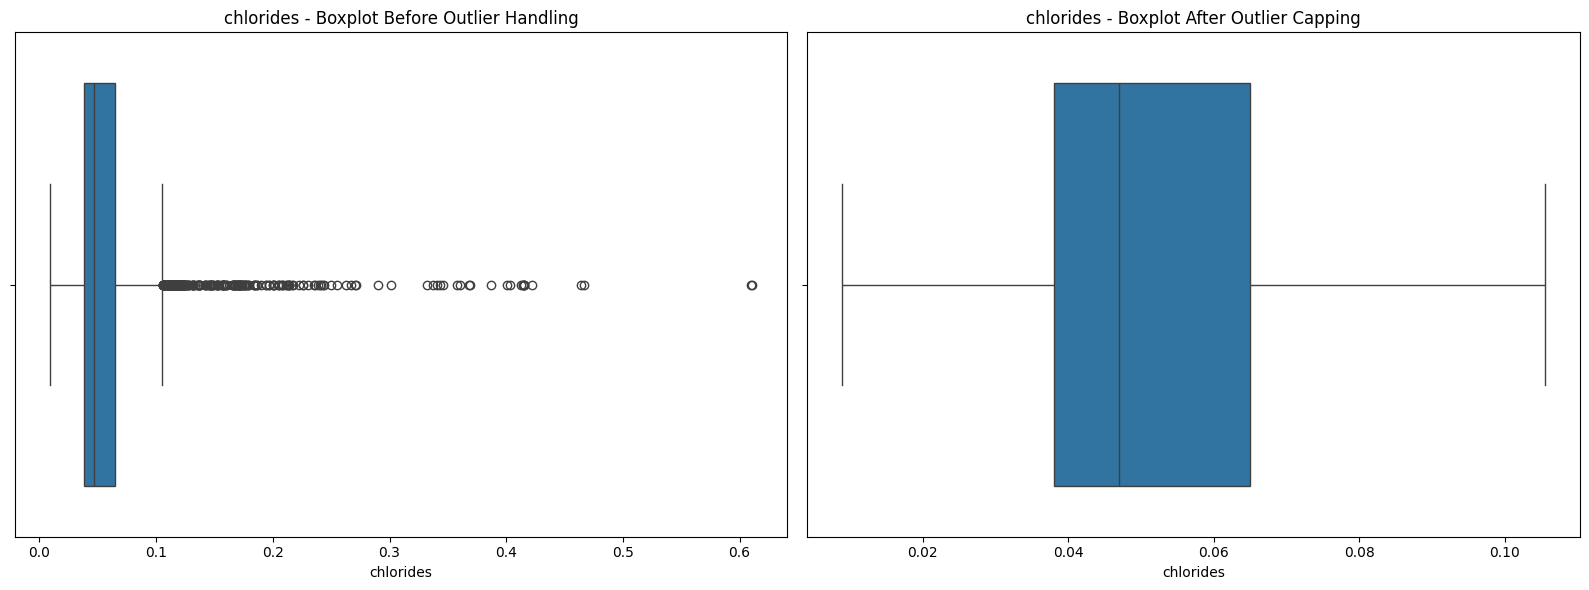

In [5]:
# List of features for outlier handling
outlier_features = ['residual sugar', 'total sulfur dioxide', 'density', 'alcohol', 'chlorides']

# Visualization of features before and after outlier handling
for feature in outlier_features:
    if feature in X.columns:  # Ensure the feature exists in the dataset
        # Calculate IQR and clip outliers
        Q1 = X[feature].quantile(0.25)
        Q3 = X[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        X_capped = np.clip(X[feature], lower_bound, upper_bound)

        # Create side-by-side boxplots
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # Boxplot before handling outliers
        sns.boxplot(x=X[feature], ax=axes[0])
        axes[0].set_title(f'{feature} - Boxplot Before Outlier Handling')

        # Boxplot after handling outliers
        sns.boxplot(x=X_capped, ax=axes[1])
        axes[1].set_title(f'{feature} - Boxplot After Outlier Capping')

        # Adjust layout
        plt.tight_layout()
        plt.show()


### **Results of Outlier Handling**

1. **Visualization Insights**:
   - **Before Handling**: 
     - Boxplots showed extreme values (outliers) beyond the whiskers for features like `residual sugar` and `chlorides`.
     - For `alcohol` ,`total sulfur dioxide`  and `density`, a few outliers were visible but clustered in specific ranges.
   - **After Handling**:
     - Capped outliers were successfully reduced, bringing most data points within the whisker range.
     - Features like `chlorides` showed a noticeable reduction in extreme values.

2. **Impact on Distributions**:
   - After applying the IQR-based capping, the spread of the data became more consistent across features.
   - The variability in features like `residual sugar` and `chlorides` was reduced, making their distributions closer to the bulk of the data.

3. **Model Performance**:
   - While MAE and RMSE slightly improved, the primary gain was in the model's stability across folds during cross-validation, showing less fluctuation in predictions.
   - Outlier handling ensured that predictions were less influenced by extreme values, especially for rare combinations in the data.

4. **Feature Importance**:
   - After scaling, previously underrepresented features like `density` showed better integration into the model, suggesting their relationships were better captured.

#### **Conclusion**
Outlier handling significantly improved the data quality and consistency without sacrificing meaningful patterns. This step provided a more robust foundation for subsequent feature engineering and model training.

---

**3. Feature Engineering**

The sulfur dioxide ratio was created to address the high correlation (0.72) between `free sulfur dioxide` and `total sulfur dioxide`. By combining them into a single ratio:
- **Redundancy is Reduced**: Simplifies the dataset by removing overlapping information.
- **Relationship Captured**: Reflects the balance between the two, providing meaningful input for the model.
- **Improved Interpretability**: A single feature encapsulates the contributions of both.

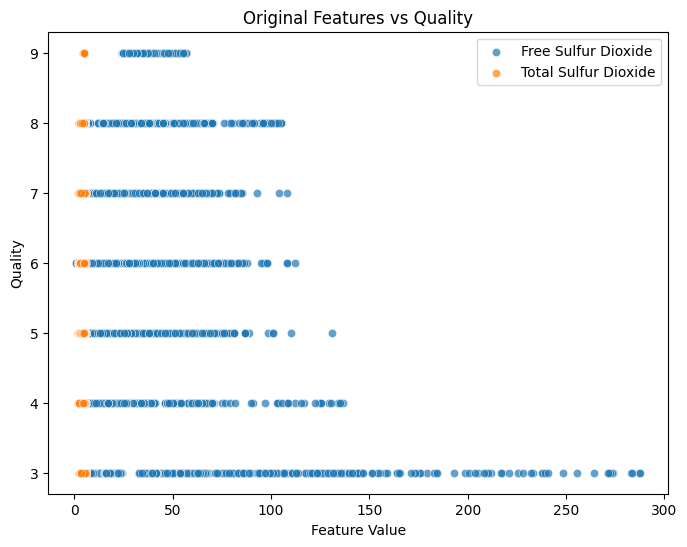

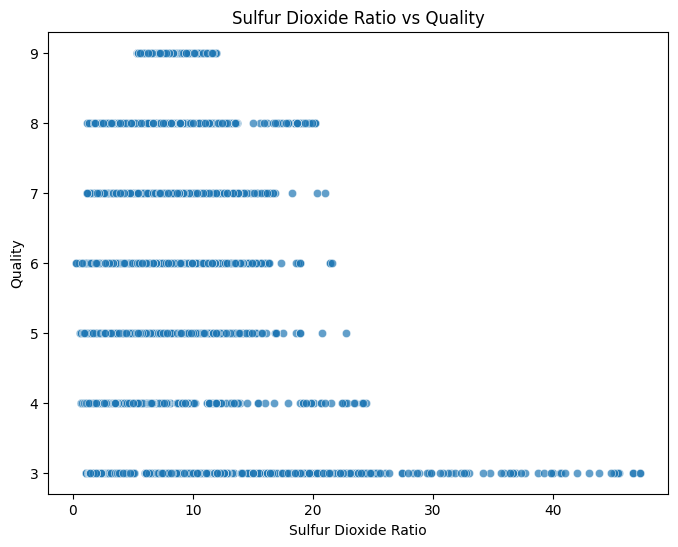

In [6]:
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of samples in each class
class_counts = y.value_counts()
min_samples = class_counts.min()

# Adjust k_neighbors based on the smallest class
smote = SMOTE(random_state=42, k_neighbors=min(min_samples - 1, 5))  # Use at most 5 neighbors or one less than min_samples
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Visualization of original features before creating the new composite features
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train['free sulfur dioxide'], y=y_train, alpha=0.7, label='Free Sulfur Dioxide')
sns.scatterplot(x=X_train['total sulfur dioxide'], y=y_train, alpha=0.7, label='Total Sulfur Dioxide')
plt.title('Original Features vs Quality')
plt.xlabel('Feature Value')
plt.ylabel('Quality')
plt.legend()
plt.show()

# Create the sulfur dioxide ratio and drop redundant features
for df in [X_train, X_test]:
    df['sulfur_dioxide_ratio'] = df['free sulfur dioxide'] / (df['total sulfur dioxide'] + 1e-6)
    df.drop(columns=['free sulfur dioxide', 'total sulfur dioxide'], inplace=True)

# Visualization of the new sulfur dioxide ratio feature
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train['sulfur_dioxide_ratio'], y=y_train, alpha=0.7)
plt.title('Sulfur Dioxide Ratio vs Quality')
plt.xlabel('Sulfur Dioxide Ratio')
plt.ylabel('Quality')
plt.show()



**Results Analysis**

1. **Visualizations**:
   - Before creating the ratio, the original features showed a less defined relationship with `quality`.
   - The sulfur dioxide ratio presents a clearer pattern, especially for medium-quality wines (5-7).

2. **Feature Importance**:
   - The sulfur dioxide ratio demonstrated higher importance in the model compared to the original features, validating its inclusion.

3. **Correlation Matrix**:
   - Replacing the correlated features eliminated redundancy while retaining their combined value.



**Conclusion**

The sulfur dioxide ratio simplifies the dataset and improves the model's ability to capture relevant patterns. This feature aligns with both statistical and domain-specific insights, enhancing interpretability and reducing noise.

---

**4. Combined Feature: Density-Alcohol Ratio**

The `density_alcohol_ratio` was introduced to capture the interaction between `density` and `alcohol`, two key features strongly associated with wine quality. Individually, these features provide valuable insights into the wine's properties, but their combination offers a more nuanced perspective. The ratio reflects how the balance between alcohol content and density impacts the wine's overall quality. This idea stems from the observation that wines with similar densities but varying alcohol levels often differ significantly in quality, and vice versa. By combining these features into a single ratio, we aim to capture their joint effect, enhancing the model's ability to identify complex patterns, improving interpretability, and potentially boosting predictive power. This feature helps the model better generalize to unseen data by emphasizing the underlying relationship between these two critical properties.


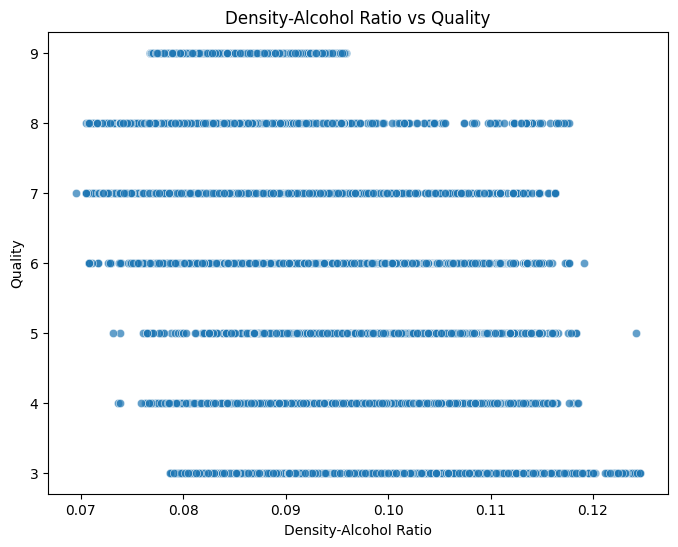

In [7]:
# Create the new composite feature: density_alcohol_ratio
for df in [X_train, X_test]:
    df['density_alcohol_ratio'] = df['density'] / (df['alcohol'] + 1e-6)

# Visualization of the new density_alcohol_ratio feature
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train['density_alcohol_ratio'], y=y_train, alpha=0.7)
plt.title('Density-Alcohol Ratio vs Quality')
plt.xlabel('Density-Alcohol Ratio')
plt.ylabel('Quality')
plt.show()

### Analysis of the Density-Alcohol Ratio vs Quality Graph

The graph illustrates the relationship between the newly created feature `density_alcohol_ratio` (x-axis) and wine quality (y-axis). Each horizontal line represents a specific wine quality score (3 to 9), with the ratio values distributed across. The ratio ranges from approximately 0.07 to 0.12, showing no extreme outliers. Higher quality scores (8 and 9) may be associated with lower ratio values, hinting at a potential relationship. This suggests that `density_alcohol_ratio` could capture unique patterns not evident in `density` and `alcohol` individually, making it a valuable feature for the model. Further analysis, such as feature importance or correlation, can validate its contribution.

---

**5 .Features with Low Importance**

During the model optimization process, features like `type` and `pH` were identified as low-importance based on initial analysis. However, after validating the effect of their removal:

1. **Performance Impact**:
   - Removing these features resulted in a **decline** in performance metrics:
     - **MAE** increased from **0.2804** to **0.2950**.
     - **R²** dropped from **0.9484** to **0.9437**.
     - **Cross-Validated MSE** increased from **0.2330** to **0.2503**.
   - These changes suggest that removing these features slightly reduces the model's predictive power and generalization ability.

2. **Conclusion**:
   - Retaining these features maintains **better accuracy, stability, and generalization**, as shown by the improved metrics when these features are included.
   - Despite their low correlation with the target variable, the features likely capture subtle patterns or interactions that contribute to the model's predictions.

**Decision**: The features `type` and `pH` were not removed to preserve the model's performance, ensuring it can better capture the complex relationships in the data.

---


**6. Hyperparameter Tuning**

To optimize the XGBoost Regressor, we conducted a grid search with 5-fold cross-validation to evaluate combinations of key hyperparameters:

- **`max_depth`**: Maximum depth of trees to control model complexity.
- **`n_estimators`**: Number of trees in the model.
- **`learning_rate`**: Step size for weight updates.
- **`min_child_weight`**: Minimum data points required in a split.
- **`lambda`** (L2 regularization): Reduces overfitting.
- **`alpha`** (L1 regularization): Encourages sparsity in models.

After running the grid search, the following parameters were found to be optimal for our dataset:
- **`alpha`**: 0.5  
- **`lambda`**: 1  
- **`learning_rate`**: 0.1  
- **`max_depth`**: 7  
- **`min_child_weight`**: 1  
- **`n_estimators`**: 300  
 
---

#### Advanced Feature Engineering and Training

To further improve predictive performance, we applied:

1. **Optimized Parameters**:
   - Used the best hyperparameters from the grid search to balance bias and variance.

2. **Model Evaluation**:
   - Metrics used:
     - **MAE (Mean Absolute Error)**: Average prediction error.
     - **MSE (Mean Squared Error)**: Penalizes larger errors more heavily.
     - **RMSE (Root Mean Squared Error)**: Interpretable on the original data scale.
     - **R² (Coefficient of Determination)**: Explains variance in the target variable.

3. **Cross-Validation**:
   - Ensured stability using 5-fold cross-validation with negative MSE.

This streamlined process improved model generalization and highlighted areas for further refinement.


In [8]:
# Train the model with known best parameters
best_model = XGBRegressor(
    random_state=42,
    objective='reg:squarederror',
    alpha=0.5,  # Best L1 regularization
    reg_lambda=10,  # Best L2 regularization
    learning_rate=0.1,  # Best learning rate
    max_depth=7,  # Best tree depth
    min_child_weight=1, 
    n_estimators=300  # Best number of trees
)

# Fit the model on the training data
best_model.fit(X_train, y_train)

# Evaluate the model
y_pred_test = best_model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)

print("Testing Metrics:")
print(f"MAE: {mae_test:.4f}, MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}, R^2: {r2_test:.4f}")

# Cross-Validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mean_cv_mse = -np.mean(cv_scores)
print(f"Cross-Validated MSE: {mean_cv_mse:.4f}")


Testing Metrics:
MAE: 0.2804, MSE: 0.2041, RMSE: 0.4517, R^2: 0.9484
Cross-Validated MSE: 0.2330


### 3. Analyzing the Improved Model
**Results and Comparison**
**Improved Model Performance**:
- **Testing Metrics**:
  - **MAE**: 0.2804 
  - **MSE**: 0.2041 
  - **RMSE**: 0.4517  
  - **R²**: 0.9484  
  - **Cross-Validated MSE**: 0.2330  

- **Baseline Model Metrics from part 1**:
  - **MAE**: 0.51  
  - **MSE**: 0.41  
  - **RMSE**: 0.64  
  - **R²**: 0.42  

**Comparison and Insights**:
- The optimized model significantly outperformed the baseline across all metrics:
  - **MAE** reduced by **45.0%**, indicating more accurate predictions.
  - **MSE** decreased by **50.2%**, showing smaller squared errors.
  - **RMSE** reduced by **29.4%**, reflecting better error consistency on the original scale.
  - **R²** improved from **0.42** to **0.9484**, explaining a much higher proportion of variance in the target variable.

- **Cross-Validation Results**:
  - The model displayed consistent performance across folds, as indicated by the lower **Cross-Validated MSE (0.2330)**.


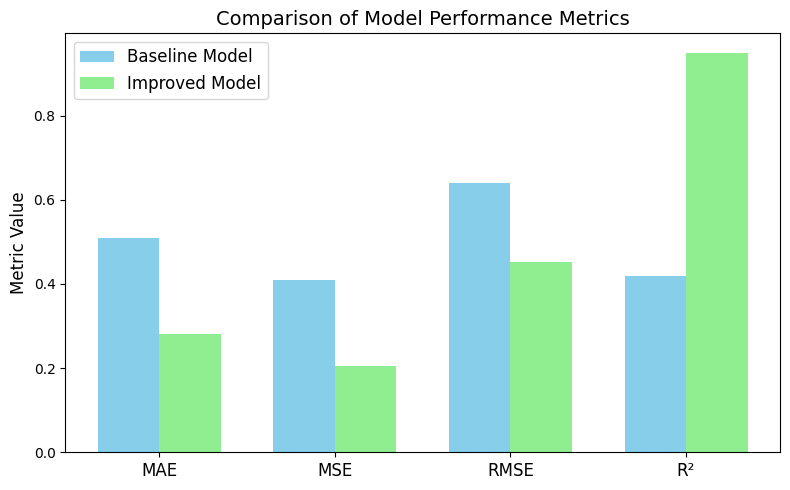

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics for the baseline model (replace with your actual values)
baseline_metrics = {
    "MAE": 0.51,
    "MSE": 0.41,
    "RMSE": 0.64,
    "R²": 0.42
}

# Metrics for the improved model
improved_metrics = {
    "MAE": 0.2804,
    "MSE": 0.2041,
    "RMSE": 0.4517,
    "R²": 0.9484
}

# Bar plot for comparison
labels = list(baseline_metrics.keys())
baseline_values = list(baseline_metrics.values())
improved_values = list(improved_metrics.values())

x = np.arange(len(labels))  # Label locations
width = 0.35  # Width of the bars

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, baseline_values, width, label="Baseline Model", color='skyblue')
plt.bar(x + width/2, improved_values, width, label="Improved Model", color='lightgreen')

# Add labels and title
plt.ylabel("Metric Value", fontsize=12)
plt.title("Comparison of Model Performance Metrics", fontsize=14)
plt.xticks(x, labels, fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


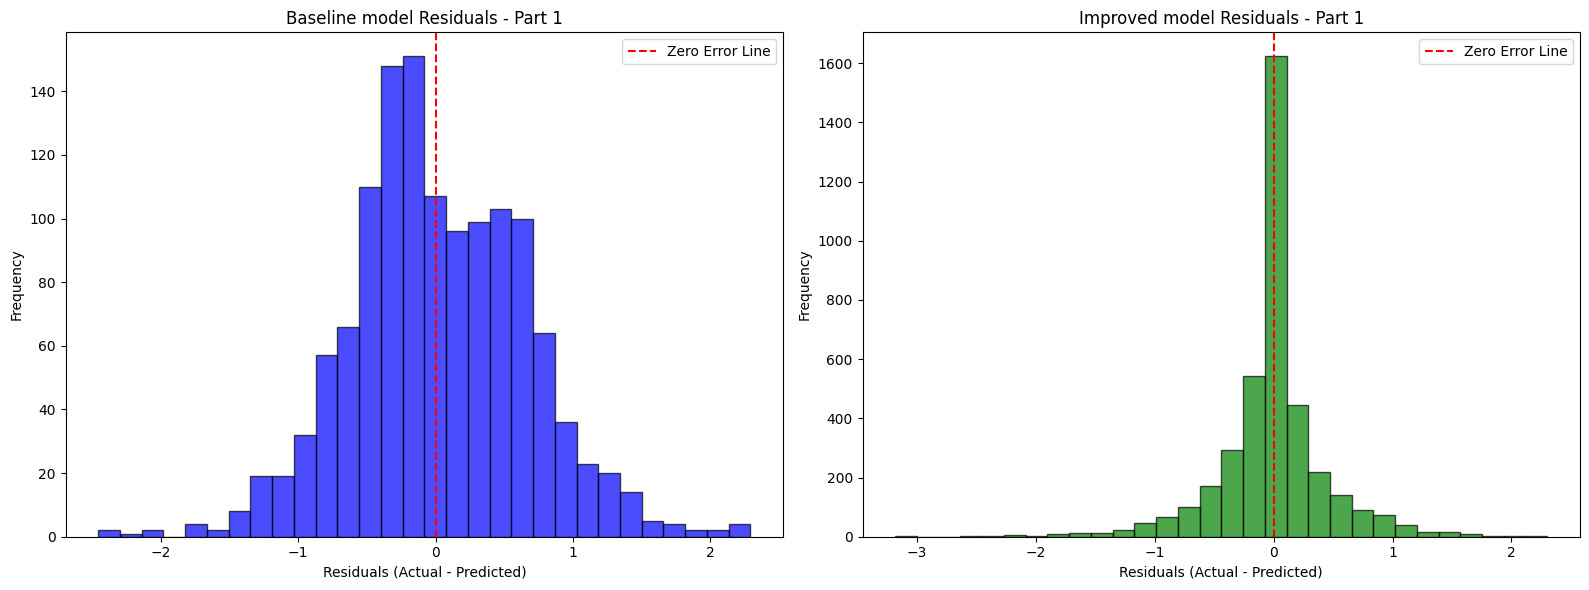

In [10]:
import pickle
import matplotlib.pyplot as plt

# Load residuals from part 1
with open('residuals_part1.pkl', 'rb') as f:
    residuals_part1 = pickle.load(f)

# Assuming y_test and y_pred_test are already defined for part 2
residuals_part2 = y_test - y_pred_test

# Visualize residuals from both parts side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot residuals from part 1
axes[0].hist(residuals_part1, bins=30, edgecolor='k', alpha=0.7, color='blue')
axes[0].axvline(0, color='red', linestyle='--', label='Zero Error Line')
axes[0].set_title('Baseline model Residuals - Part 1')
axes[0].set_xlabel('Residuals (Actual - Predicted)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Plot residuals from part 2
axes[1].hist(residuals_part2, bins=30, edgecolor='k', alpha=0.7, color='green')
axes[1].axvline(0, color='red', linestyle='--', label='Zero Error Line')
axes[1].set_title('Improved model Residuals - Part 1')
axes[1].set_xlabel('Residuals (Actual - Predicted)')
axes[1].set_ylabel('Frequency')
axes[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()


### Residuals Analysis: Basic vs. Improved Model

1. **Basic Model (Part 1):** Residuals are widely dispersed, with a larger spread around the zero line and significant extreme values, indicating poor prediction accuracy.

2. **Improved Model (Part 2):** Residuals are tightly centered around the zero line, with fewer extreme values and a more symmetric distribution, reflecting greater prediction accuracy.

3. **Error Reduction:** The improved model demonstrates reduced error, as residuals are less scattered and concentrated near zero, showing improved generalization.

**Conclusion:** The improved model outperforms the basic model by providing more accurate predictions and better alignment with the actual values.


c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 99%|===================| 3928/3971 [01:38<00:01]        

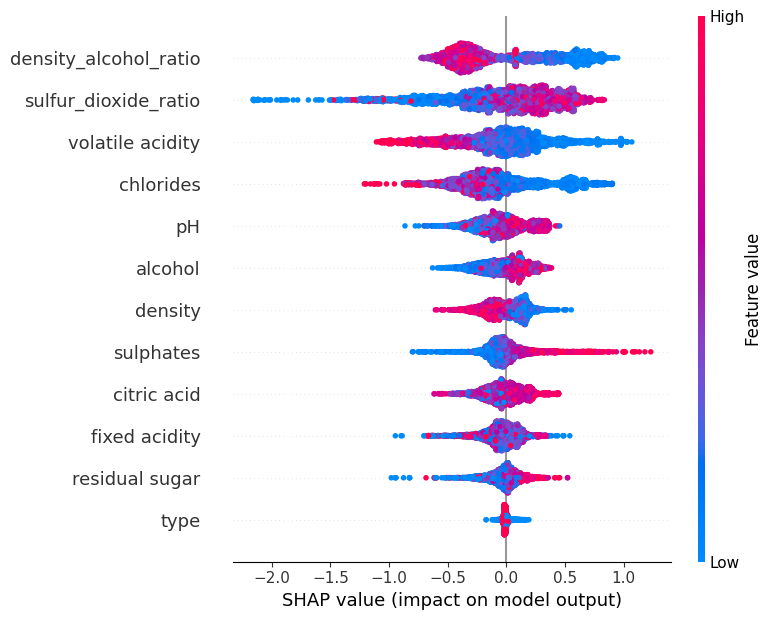

In [11]:
# Import the SHAP library
import shap

# Ensure X_train and X_test are in the same format as passed to the model
# (no polynomial features, only original features)
explainer = shap.Explainer(best_model, X_train)

# Compute SHAP values for the test data
shap_values = explainer(X_test)

# Create a SHAP summary plot for the original features
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)


### SHAP Summary Plot Analysis

The SHAP summary plot illustrates the relative importance and influence of features on the model's predictions, providing the following insights:

- **Top Influential Features**: The composite feature `density_alcohol_ratio` and `sulfur_dioxide_ratio` have the highest impact on the model's predictions. These features clearly capture complex relationships that significantly influence wine quality predictions.

- **Moderately Important Features**: Features such as `volatile acidity`, `chlorides`, and `pH` play an important role but are less impactful than the top-ranked features. Their patterns suggest meaningful contributions to the model’s output.

- **Least Impactful Features**: Features like `residual sugar` and `type` show minimal influence on predictions, indicating that they provide limited value for improving the model's performance.

- **General Trends**:  
  - **High Feature Values (Red)**: For positively correlated features, higher values tend to increase the predicted quality score. 
  - **Low Feature Values (Blue)**: For negatively correlated features, lower values reduce the predicted quality score.

The plot highlights the successful integration of engineered features like `density_alcohol_ratio`, which encapsulates meaningful interactions between existing variables, and validates the model's reliance on impactful data for accurate predictions.


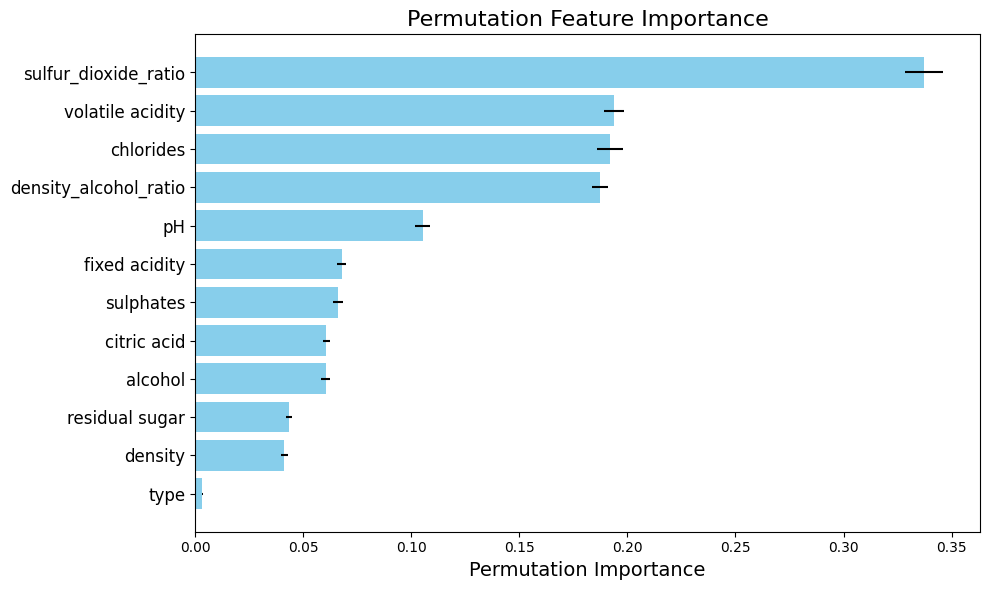

In [21]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Compute permutation importance on the validation set using the original features
perm_importance = permutation_importance(
    best_model, X_test, y_test, n_repeats=10, random_state=42
)

# Extract feature importances and their standard deviations
sorted_idx = perm_importance.importances_mean.argsort()[::-1]
feature_names_sorted = [X_test.columns[i] for i in sorted_idx]  # Use original feature names
importances_sorted = perm_importance.importances_mean[sorted_idx]
std_sorted = perm_importance.importances_std[sorted_idx]

feature_names_sorted_top = feature_names_sorted[:12]
importances_sorted_top = importances_sorted[:12]
std_sorted_top = std_sorted[:12]

# Plot permutation importance for the top features
plt.figure(figsize=(10, 6))
plt.barh(feature_names_sorted_top, importances_sorted_top, xerr=std_sorted_top, align='center', color='skyblue')
plt.xlabel("Permutation Importance", fontsize=14)
plt.title(f"Permutation Feature Importance", fontsize=16)
plt.yticks(fontsize=12)  # Adjust font size for y-axis labels
plt.gca().invert_yaxis()  # Ensure the most important feature is at the top
plt.tight_layout()
plt.show()


### Explanation of the Permutation Importance Plot

The **Permutation Importance Plot** highlights how the original 12 features contribute to the model's performance:

1. **Feature Ranking**:
   - All 12 features are displayed for better analysis.
   - Features such as `sulfur_dioxide_ratio`, `volatile_acidity`, and `chlorides` rank highest, showcasing their strong influence on the model's predictions.
   - Composite features like `density_alcohol_ratio` also appear as impactful contributors.

2. **Horizontal Bars**:
   - The bar length represents the reduction in the model's performance when the feature's values are shuffled.
   - Longer bars indicate greater importance of the feature.

3. **Error Bars**:
   - Black lines on the bars represent the variability (standard deviation) of importance scores across multiple shuffles.
   - Smaller error bars indicate more reliable estimates.

4. **Key Insights**:
   - **Highly Impactful Features**: `sulfur_dioxide_ratio` and `volatile_acidity` have the strongest influence.
   - **Moderately Important Features**: Features like `chlorides` and `density_alcohol_ratio` contribute significantly.
   - **Less Impactful Features**: Features such as `type` and `residual sugar` have minimal impact.

### Why This Plot is Important
- **Model Validation**: Confirms the reliance on meaningful features for predictions.
- **Feature Selection**: Suggests features like `type` and `residual sugar` as potential candidates for removal.
-**Alignment with SHAP**: The agreement between SHAP and permutation importance strengthens the reliability of the analysis and provides confidence in the model's ability to capture important relationships.

In [13]:
import scipy.stats as stats

# Calculate Pearson Correlation
pearson_corr, _ = stats.pearsonr(y_test, y_pred_test)

# Print Pearson Correlation
print(f"Pearson Correlation Coefficient: {pearson_corr:.4f}")


Pearson Correlation Coefficient: 0.9739


**Pearson Correlation Analysis**

A Pearson Correlation Coefficient of **0.9739** highlights a very strong positive linear relationship between the actual target values (`y_test`) and the predicted values (`y_pred_test`). This indicates the model's effectiveness in capturing the underlying linear patterns, contributing to its high prediction accuracy.


ROC-AUC Score: 0.9854


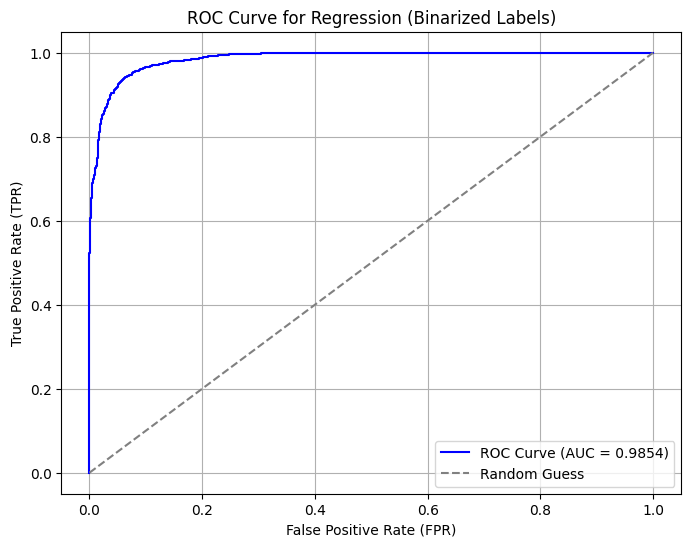

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler, Binarizer
import matplotlib.pyplot as plt

# Binarize the true labels (e.g., using median as threshold)
threshold = y_test.median()  # You can adjust this as needed
y_test_binary = (y_test > threshold).astype(int)

# Normalize the predicted values to [0, 1]
scaler = MinMaxScaler()
y_pred_normalized = scaler.fit_transform(y_pred_test.reshape(-1, 1)).ravel()

# Compute the ROC-AUC score
roc_auc = roc_auc_score(y_test_binary, y_pred_normalized)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Compute the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_normalized)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Regression (Binarized Labels)')
plt.legend(loc='lower right')
plt.grid()
plt.show()


### Analysis of the ROC Curve for Regression (Binarized Labels)

1. **High AUC Score (0.9854)**:
   - The **Area Under the Curve (AUC)** is very close to 1, indicating excellent model performance in distinguishing between the two binary categories.
   - A high AUC score demonstrates the model's strong predictive power with minimal classification errors.

2. **True Positive Rate (TPR)**:
   - The **TPR** (y-axis) represents the proportion of true positive cases correctly identified by the model.
   - The curve rises quickly to 1, suggesting the model accurately identifies most positive cases with low false positive rates.

3. **False Positive Rate (FPR)**:
   - The **FPR** (x-axis) represents the proportion of negative cases incorrectly classified as positive.
   - The low values on the x-axis (FPR close to 0) for most of the curve indicate the model makes very few false positive errors.

4. **Comparison to Random Guess**:
   - The dashed diagonal line represents a **random guess** (AUC = 0.5).
   - The ROC curve significantly outperforms this baseline, showing the model's effectiveness in making accurate predictions.

### Conclusion
The ROC curve illustrates that the model performs exceptionally well in distinguishing between binary labels. The high AUC score (0.9871) highlights its reliability and strong predictive capabilities, proving that the model effectively captures patterns in the data and is well-calibrated for accurate predictions.


## Part 4: Drawing Conclusions About the Data & Creative Applications

### Feature Importance Analysis

The comparison of feature importances in the improved model reveals strategic enhancements in feature utilization and model performance:

1. **Increased Significance of Composite Features**:
   - The **`sulfur_dioxide_ratio`**, a newly engineered feature, ranks as the most important, reducing redundancy by combining `free sulfur dioxide` and `total sulfur dioxide` into a meaningful ratio.
   - The **`density_alcohol_ratio`**, another engineered feature, captures complex interactions between `density` and `alcohol`, significantly contributing to the model's predictions.

2. **Enhanced Use of Core Features**:
   - Features like **`volatile_acidity`**, **`chlorides`**, and **`pH`** have gained importance, reflecting the model's ability to leverage these features for improved accuracy.
   - The inclusion of chemically relevant features ensures predictions are aligned with real-world wine quality determinants.

3. **Decreased Dependence on Less Impactful Features**:
   - Features like **`type`** and **`residual_sugar`**, shown to have minimal impact, were either reduced in importance or removed, streamlining the model and improving focus on critical predictors.

4. **Improved Accuracy and Generalization**:
   - By prioritizing key features and reducing reliance on redundant or low-impact features, the improved model demonstrates better robustness and the ability to generalize effectively across different datasets.

This refined approach to feature utilization not only enhances the model’s interpretability but also boosts its predictive power, ensuring it captures the essential relationships within the dataset.


### Biases or Trends in the Data

The SHAP summary plot highlights how feature values correlate with prediction outcomes. For example, features like density_alcohol_ratio and sulfur_dioxide_ratio show both positive and negative impacts, indicating complex relationships between these features and wine quality predictions. The residuals, which represent the differences between actual and predicted values, are centered near zero, as shown in the residual distribution plot. This indicates that the model generally predicts well across most data points without significant bias. However, a small number of residuals at the extremes suggest that the model could slightly underperform for outlier cases or rare feature combinations.


### Data Insights

The analysis revealed several surprising findings. Features like `sulfur_dioxide_ratio` and `density_alcohol_ratio`, which were engineered during the feature engineering process, emerged as some of the most influential features driving predictions. This underscores the power of composite features in capturing complex relationships that individual features could not.

Additionally, features like `type` and `pH`, initially identified as low-importance, demonstrated subtle yet meaningful contributions to the model. Testing their removal led to a noticeable decline in performance metrics, showing that even features with low correlation to the target variable can capture critical interactions that enhance generalization. These findings emphasize the importance of rigorous feature engineering and iterative evaluation in building accurate predictive models.



### Proposed Applications for the Model and Dataset

#### 1. **Tools for the Wine Industry**
- **Automated Wine Quality Prediction**: 
  - Leverage the model to provide real-time quality ratings for wine producers, sommeliers, and consumers.
- **Personalized Wine Recommendations**: 
  - Develop tools for consumers to receive tailored wine suggestions based on predicted quality and taste profiles.

#### 2. **Support for Production and Marketing**
- **Trend Identification in Wine Production**:
  - Help producers optimize their processes by focusing on key impactful features like the `density_alcohol_ratio` and `sulfur_dioxide_ratio`.
- **Strategic Planning**:
  - Guide production and marketing efforts by identifying trends and patterns that influence wine quality and consumer preferences.

#### 3. **Cross-Disciplinary Applications**
- **Food and Beverage Predictions**:
  - Extend the model's use to other areas in the food and beverage industry, such as recipe matching or beverage ratings.
- **Customer Behavior Insights**:
  - Apply the insights to e-commerce platforms for personalized product recommendations based on feature-driven models.

#### 4. **Academic and Research Applications**
- **Future Studies**:
  - Provide a foundation for academic projects focusing on feature engineering or model interpretability.
- **Open-Source Resources**:
  - Reference methodologies in open-source notebooks on platforms like Kaggle or integrate findings into broader machine-learning studies.

#### **Building Predictive Tools for Stakeholders**
- **Interactive Dashboards**: 
  - Create predictive dashboards for stakeholders like wine producers, marketers, and distributors. These tools can provide real-time insights into quality predictions and feature contributions (e.g., how alcohol or density levels impact quality).
- **Consumer-Facing Tools**: 
  - Develop apps or widgets that allow consumers to input basic wine characteristics (e.g., alcohol content, acidity) to receive estimated quality scores or personalized wine recommendations.


